# The notebook for understanding about audio data and how to process it.

Below code is Speech-to-Speech model using speecht5 model.
However, I don't understanding many things about audio data and how to process it.
- What is the audio data?
- What is processor
- What is microsoft/speecht5_vc
- What is vocoder



## 2) What is the processor?

- In the Hugging Face Transformers library, a "processor" for audio usually **combines**:
  1. A **feature extractor** (for speech audio), and
  2. A **tokenizer** (for text), 
  …into a **single class**.  

For **SpeechT5**, this is `SpeechT5Processor`, which handles:
- **Audio feature extraction** (e.g., converting your raw waveform into log-mel spectrogram features).
- **Text processing** (tokenizing or detokenizing text, if you also have text-based inputs/outputs).

Essentially, the processor is a wrapper that makes it easy to prepare both audio and text to the correct format that the model expects. You’ll see it do something like:

```python
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_vc")

# For speech input:
inputs = processor(audio=waveform, sampling_rate=16_000, return_tensors="pt")

# For text input (in text-to-speech or ASR tasks):
inputs = processor(text="Hello world", return_tensors="pt")
```

---

## 3) What is `microsoft/speecht5_vc`?

- **`microsoft/speecht5_vc`** is a *pretrained model* hosted on the Hugging Face Hub. Specifically, it’s a SpeechT5 model variant specialized for **Voice Conversion** (VC). 
  - Voice Conversion means: “Given a speech sample from one speaker, transform it so that it sounds like a different speaker *without changing* the linguistic content.”  
- The model uses the SpeechT5 encoder-decoder architecture under the hood, which can handle multiple speech tasks with different pre/post-nets (e.g., for ASR, TTS, VC, etc.). 
- By pulling `microsoft/speecht5_vc`, you get the trained weights plus the model configuration that Microsoft researchers created and made publicly available.

---

## 5) What is a vocoder?

- A **vocoder** in modern deep-learning pipelines is a module that converts an **acoustic feature representation** (such as a Mel spectrogram) back into a raw audio waveform. 
- Early speech synthesizers had “classical” DSP-based vocoders, but in deep learning we usually see neural vocoders, such as:
  - WaveNet
  - WaveGlow
  - HiFi-GAN
  - UnivNet
- Essentially, these models learn how to “fill in” the time-domain details that match the input spectrogram, creating natural-sounding speech. So if your SpeechT5 model outputs a Mel spectrogram, you then use a vocoder to reconstruct a final `.wav` waveform from that spectrogram.

---

### Putting it all together
1. **You have raw audio** (audio data) to process.
2. **torchaudio** can load that audio into a PyTorch tensor.
3. **The SpeechT5Processor** will convert the raw audio into the log-mel spectrogram format or vice versa, handle any text inputs, and generate the right inputs to the model.
4. **`microsoft/speecht5_vc`** is the specialized SpeechT5 model for voice conversion tasks. You load it, pass in the processed features, and get a predicted Mel spectrogram for the converted voice output.
5. **A vocoder** then converts that predicted Mel spectrogram back to a playable waveform.

This pipeline allows you to do tasks like: “Take an utterance from speaker A, produce the same utterance but in speaker B’s voice,” or even “Take text input and produce a waveform that sounds like a specific speaker.”

---

**Summary**  
- **Audio data** = the raw waveforms (or feature representations) that represent sound.  
- **torchaudio** = PyTorch’s library to handle audio loading, transforms, augmentation, etc.  
- **Processor** = a Hugging Face convenience class that combines audio feature extraction & text tokenization.  
- **`microsoft/speecht5_vc`** = Microsoft’s pretrained SpeechT5 voice-conversion model.  
- **Vocoder** = a network that turns Mel spectrograms (or other features) into final time-domain waveforms.

## 1) What is audio data?

- **Audio data** typically refers to a digitized representation of sound waves. In speech-related tasks, we usually start with raw audio waveforms (e.g. a `.wav` file) that represent amplitude values over time.
- In many speech-processing pipelines, these raw waveforms are transformed into features such as **log-mel spectrograms** or **MFCCs** before passing them to a machine learning model. These features compress important information about pitch, loudness, and timbre.


- **Sampling** The sampling rate (or sampling frequency) refers to the number of samples of audio taken per second when converting an analog signal into a digital signal.
- When a sound is recorded, the microphone captures the continuous sound wave. The Analog-to-Digital Converter (ADC) samples the wave at discrete intervals, storing values as digital data.

In [21]:
import torchaudio
from IPython.display import Audio, display

audio_file_path = "../data/audios/audio_0.wav"
waveform_before, sample_rate = torchaudio.load(audio_file_path)

waveform_before.shape, sample_rate
print(f"{waveform_before.shape=}, {sample_rate=}")
print(f"{(waveform_before.shape[1] / sample_rate)=}, and it is seconds")
display(Audio(audio_file_path))

waveform_before.shape=torch.Size([1, 41280]), sample_rate=16000
(waveform_before.shape[1] / sample_rate)=2.58, and it is seconds


## 2) What is the processor?

- In the Hugging Face Transformers library, a "processor" for audio usually **combines**:
  1. A **feature extractor** (for speech audio)
  2. A **tokenizer** (for text)

For **SpeechT5**, this is `SpeechT5Processor`, which handles:
- **Audio feature extraction** (e.g., converting your raw waveform into log-mel spectrogram features).
- **Text processing** (tokenizing or detokenizing text, if you also have text-based inputs/outputs).

In [27]:
from transformers import (
    SpeechT5Processor,
)

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_vc")

# For speech input:
# Resample waveform_before, sample_rate to 16_000 Hz
waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16_000)(waveform_before)
audio_inputs = processor(audio=waveform, sampling_rate=16_000, return_tensors="pt")
print(f"{audio_inputs=}")
print(f"{audio_inputs['input_values'].shape=}\n")

# For text input (in text-to-speech or ASR tasks):
text_inputs = processor(text="Hello world", return_tensors="pt")
print(f"{text_inputs=}")
print(f"{text_inputs['input_ids'].shape=}\n")

audio_inputs={'input_values': tensor([[[-9.4604e-04, -2.3804e-03, -1.3123e-03,  ..., -9.1553e-05,
           3.0518e-04, -2.4414e-04]]]), 'attention_mask': tensor([[1]], dtype=torch.int32)}
audio_inputs['input_values'].shape=torch.Size([1, 1, 41280])

text_inputs={'input_ids': tensor([[ 4, 35,  5, 15, 15,  8,  4, 20,  8, 13, 15, 14,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
text_inputs['input_ids'].shape=torch.Size([1, 13])



## 3) What is `microsoft/speecht5_vc`?

- **`microsoft/speecht5_vc`** is a *pretrained model* hosted on the Hugging Face Hub. Specifically, it’s a SpeechT5 model variant specialized for **Voice Conversion** (VC). 
  - Voice Conversion means: “Given a speech sample from one speaker, transform it so that it sounds like a different speaker *without changing* the linguistic content.”  
- The model uses the SpeechT5 encoder-decoder architecture under the hood, which can handle multiple speech tasks with different pre/post-nets (e.g., for ASR, TTS, VC, etc.). 
- By pulling `microsoft/speecht5_vc`, you get the trained weights plus the model configuration that Microsoft researchers created and made publicly available.

In [ ]:
from transformers import (
    SpeechT5ForSpeechToSpeech,
)

model = SpeechT5ForSpeechToSpeech.from_pretrained("microsoft/speecht5_vc")
model

Some weights of SpeechT5ForSpeechToSpeech were not initialized from the model checkpoint at microsoft/speecht5_vc and are newly initialized: ['speecht5.encoder.prenet.pos_sinusoidal_embed.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SpeechT5ForSpeechToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithSpeechPrenet(
      (prenet): SpeechT5SpeechEncoderPrenet(
        (feature_encoder): SpeechT5FeatureEncoder(
          (conv_layers): ModuleList(
            (0): SpeechT5GroupNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (activation): GELUActivation()
              (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
            )
            (1-4): 4 x SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (5-6): 2 x SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
          )
        )
        (feature_projection): SpeechT5FeatureProjection(
          (layer_norm): LayerNorm((512,

In [1]:
import os

import matplotlib.pyplot as plt
import torchaudio
from IPython.display import Audio, display


# Save audio to a file
def save_audio(waveform, sample_rate, file_name):
    torchaudio.save(file_name, waveform, sample_rate)


def plot_waveforms_and_spectrograms(waveform_before, waveform_after, sample_rate):
    output_dir = "../data/outputs"
    os.makedirs(output_dir, exist_ok=True)

    # File names
    file_name_before = os.path.join(output_dir, "original.wav")
    file_name_after = os.path.join(output_dir, "processed.wav")

    # Save audio files
    torchaudio.save(file_name_before, waveform_before, sample_rate)
    torchaudio.save(file_name_after, waveform_after, sample_rate)

    # Display saved audio
    print("Original Audio:")
    display(Audio(file_name_before))
    print("Processed Audio:")
    display(Audio(file_name_after))

    # Compute Mel Spectrograms
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)
    mel_spectrogram_before = transform(waveform_before)
    mel_spectrogram_after = transform(waveform_after)

    # Plot Waveforms and Spectrograms Side-by-Side
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Waveform Before
    axes[0, 0].plot(waveform_before.t().numpy())
    axes[0, 0].set_title("Waveform (Before Processing)")
    axes[0, 0].set_xlabel("Time (samples)")
    axes[0, 0].set_ylabel("Amplitude")
    axes[0, 0].grid()

    # Waveform After
    axes[0, 1].plot(waveform_after.t().numpy())
    axes[0, 1].set_title("Waveform (After Processing)")
    axes[0, 1].set_xlabel("Time (samples)")
    axes[0, 1].set_ylabel("Amplitude")
    axes[0, 1].grid()

    # Spectrogram Before
    img_before = axes[1, 0].imshow(
        mel_spectrogram_before.log2()[0, :, :].numpy(),
        cmap="viridis",
        origin="lower",
        aspect="auto",
    )
    axes[1, 0].set_title("Mel Spectrogram (Before Processing)")
    axes[1, 0].set_xlabel("Time (frames)")
    axes[1, 0].set_ylabel("Mel Frequency (bins)")
    fig.colorbar(img_before, ax=axes[1, 0], orientation="vertical", fraction=0.046, pad=0.04)

    # Spectrogram After
    img_after = axes[1, 1].imshow(
        mel_spectrogram_after.log2()[0, :, :].numpy(),
        cmap="viridis",
        origin="lower",
        aspect="auto",
    )
    axes[1, 1].set_title("Mel Spectrogram (After Processing)")
    axes[1, 1].set_xlabel("Time (frames)")
    axes[1, 1].set_ylabel("Mel Frequency (bins)")
    fig.colorbar(img_after, ax=axes[1, 1], orientation="vertical", fraction=0.046, pad=0.04)

    # Adjust layout
    plt.tight_layout()
    plt.show()

Some weights of SpeechT5ForSpeechToSpeech were not initialized from the model checkpoint at microsoft/speecht5_vc and are newly initialized: ['speecht5.encoder.prenet.pos_sinusoidal_embed.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:spee

Original Audio:


Processed Audio:


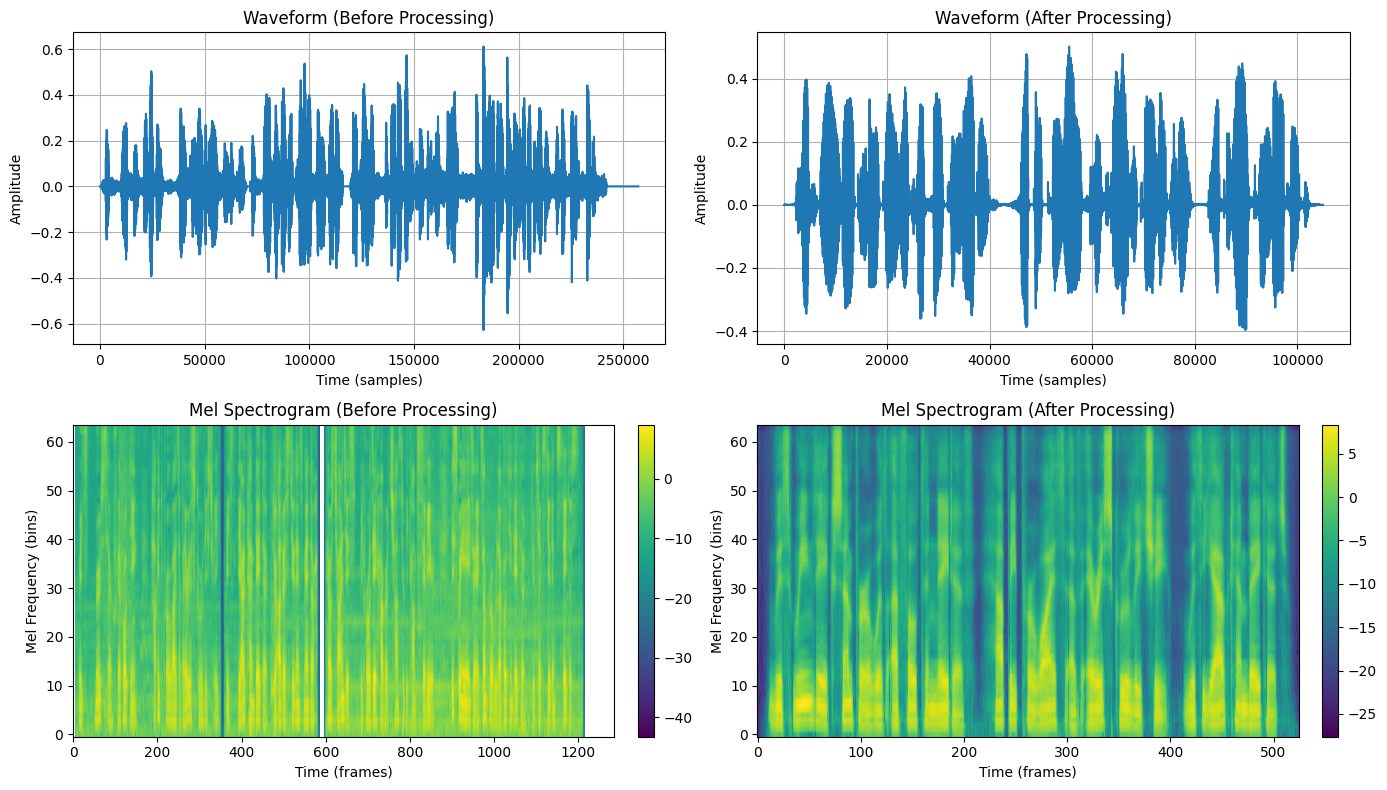

In [ ]:
import torch
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from transformers import SpeechT5ForSpeechToSpeech, SpeechT5HifiGan, SpeechT5Processor

SAMPLING_RATE = 16000


class EnglishAccentCorrectionSTS:
    def __init__(self, device=None, sampling_rate=SAMPLING_RATE):
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.sampling_rate = sampling_rate

        self._load_models()

    def _load_models(self):
        """Load the necessary models."""
        self.processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_vc")
        self.model = SpeechT5ForSpeechToSpeech.from_pretrained("microsoft/speecht5_vc").to(self.device)
        self.vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(self.device)

        spk_model_name = "speechbrain/spkrec-xvect-voxceleb"
        self.speaker_model = EncoderClassifier.from_hparams(
            source=spk_model_name, run_opts={"device": self.device}, savedir=os.path.join("/tmp", spk_model_name)
        )

    def load_audio(self, file_path, target_sr=16000):
        """Load an audio file and convert it to the target sampling rate."""
        waveform, sr = torchaudio.load(file_path)

        if waveform.shape[0] > 1:  # Convert stereo to mono
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != target_sr:  # Resample if necessary
            waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)(waveform)

        return waveform.squeeze(0).numpy(), target_sr

    def extract_speechbrain_embedding(self, audio_array):
        """Extract a 512-dimensional speaker embedding from SpeechBrain."""
        with torch.no_grad():
            speaker_embeddings = self.speaker_model.encode_batch(
                torch.tensor(audio_array).unsqueeze(0).to(self.device)
            )
            speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        return speaker_embeddings.squeeze().cpu().numpy()

    def extract_speaker_embeddings(self, audio_array):
        """Extract speaker embeddings using SpeechBrain."""
        return self.extract_speechbrain_embedding(audio_array)

    def generate_speech(self, audio_array, sample_rate=None):
        """Process an audio array to generate corrected speech using SpeechT5."""
        sample_rate = sample_rate if sample_rate else self.sampling_rate

        inputs = self.processor(audio=audio_array, sampling_rate=sample_rate, return_tensors="pt").to(self.device)
        embeddings = self.extract_speaker_embeddings(audio_array)
        speaker_embeddings = torch.Tensor(embeddings).unsqueeze(0).to(self.device)

        with torch.no_grad():
            waveform_corrected = self.model.generate_speech(
                inputs["input_values"], speaker_embeddings, vocoder=self.vocoder
            )

        return waveform_corrected.unsqueeze(0)


# Example usage
if __name__ == "__main__":
    audio_path = "../data/audios/audio_0.wav"
    audio_path = "../data/audios/seahack-masa.wav"
    accent_corrector = EnglishAccentCorrectionSTS()
    original_waveform, sample_rate = accent_corrector.load_audio(audio_path)
    corrected_waveform = accent_corrector.generate_speech(original_waveform)
    torchaudio.save("../data/outputs/corrected.wav", corrected_waveform, sample_rate)

    original_waveform = torch.tensor(original_waveform).unsqueeze(0)
    plot_waveforms_and_spectrograms(original_waveform, corrected_waveform, 16000)

In [4]:
audio_path = "../data/audios/audio_0.wav"
audio_path = "../data/audios/seahack-masa.wav"
original_array, sample_rate = accent_corrector.load_audio(audio_path)

In [5]:
from transformers import UniSpeechSatForAudioFrameClassification, Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/unispeech-sat-large-sd")
model = UniSpeechSatForAudioFrameClassification.from_pretrained("microsoft/unispeech-sat-large-sd")

pytorch_model.bin:  51%|#####     | 640M/1.26G [00:00<?, ?B/s]

In [ ]:
inputs = feature_extractor(original_array, return_tensors="pt")
logits = model(**inputs).logits
probabilities = torch.sigmoid(logits[0])
# labels is a one-hot array of shape (num_frames, num_speakers)
labels = (probabilities > 0.5).long()

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


(torch.Size([803, 2]), tensor([739, 512]))

In [7]:
inputs

{'input_values': tensor([[0.0015, 0.0015, 0.0015,  ..., 0.0015, 0.0015, 0.0015]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}